## Create PyTorch Dataset

In [6]:
import os
from PIL import Image
import torch
from torch.utils.data import Dataset
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from torchvision import transforms
from skimage import io

import torch
from torch.utils.data import DataLoader
from transformers import Blip2ForConditionalGeneration, AdamW
from tqdm import tqdm
from torchmetrics.text.rouge import ROUGEScore
from torchmetrics.text.bleu import BLEUScore
# from torchmetrics.text.meteor import METEORScore
# from torchmetrics.text.cider import CIDERScore
import os


class ROCODataset(Dataset):
    def __init__(
        self,
        root_dir: str,
        train: bool = False,
        valid: bool = False,
        test: bool = False,
        transform=None
    ):
        self.root_dir = root_dir
        self.transform = transform
        self.train = train
        self.valid = valid
        self.test = test

        self.train_dir = os.path.join(root_dir, 'train5')
        self.val_dir = os.path.join(root_dir, 'valid3')
        self.test_dir = os.path.join(root_dir, 'test3')

        self.captions = {}
        caption_files = {
            'train': f'{root_dir}/train_captions5.csv',
            'valid': f'{root_dir}/valid_captions3.csv',
            'test': f'{root_dir}/test_captions3.csv'
        }

        for caption in caption_files:
            df = pd.read_csv(caption_files[caption])
            self.captions[caption] = df.set_index('ID').to_dict()['Caption']

        df = pd.read_csv(f'{root_dir}/cui_mapping.csv')
        self.cui_mapping = df.set_index('CUI').to_dict()['Canonical name']

        self.train_len = len(self.captions['train'])
        self.valid_len = len(self.captions['valid'])
        self.test_len = len(self.captions['test'])

    def __len__(self):
        length = 0
        if self.train:
            length += self.train_len
        if self.valid:
            length += self.valid_len
        if self.test:
            length += self.test_len
        return length

    def __getitem__(self, idx) -> dict:
        file_name = ''
        image_loc = ''
        caption = ''

        if self.train:
            file_name = list(self.captions['train'].keys())[idx]
            caption = self.captions['train'][file_name]
            image_loc = os.path.join(self.root_dir, 'train', f'{file_name}.jpg')
        elif self.valid:
            file_name = list(self.captions['valid'].keys())[idx]
            caption = self.captions['valid'][file_name]
            image_loc = os.path.join(self.root_dir, 'valid', f'{file_name}.jpg')
        elif self.test:
            file_name = list(self.captions['test'].keys())[idx]
            caption = self.captions['test'][file_name]
            image_loc = os.path.join(self.root_dir, 'test', f'{file_name}.jpg')

        img = io.imread(image_loc)

        if self.transform:
            img = self.transform(img)

        return {'image': img, 'text': caption}


# # Define a transform to resize images to 256x256 pixels
# data_transform = transforms.Compose([
#     transforms.ToPILImage(),  # Convert numpy array to PIL image
#     transforms.Resize((224, 224)),  # Resize the image to 256x256 pixels
#     transforms.ToTensor(),  # Convert PIL image to tensor
    # transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
# ])

root_dir = "/home/CinCin/code/dataset"
train_data = ROCODataset(root_dir, train=True)
valid_data = ROCODataset(root_dir, valid=True)
test_data = ROCODataset(root_dir, test=True)

In [7]:
from torch.utils.data import Dataset, DataLoader

class ImageCaptioningDataset(Dataset):
    def __init__(self, dataset, processor):
        self.dataset = dataset
        self.processor = processor

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        item = self.dataset[idx]
        encoding = self.processor(images=item["image"], padding="max_length", return_tensors="pt")
        # remove batch dimension
        encoding = {k: v.squeeze() for k, v in encoding.items()}
        encoding["text"] = item["text"]
        return encoding

def collate_fn(batch):
    # pad the input_ids and attention_mask
    processed_batch = {}
    for key in batch[0].keys():
        if key != "text":
            processed_batch[key] = torch.stack([example[key] for example in batch])
        else:
            text_inputs = processor.tokenizer(
                [example["text"] for example in batch], padding=True, return_tensors="pt"
            )
            processed_batch["input_ids"] = text_inputs["input_ids"]
            processed_batch["attention_mask"] = text_inputs["attention_mask"]
    return processed_batch


## Load model and processor

In [8]:
from transformers import AutoProcessor, Blip2ForConditionalGeneration,BitsAndBytesConfig

quantization_config = BitsAndBytesConfig(load_in_8bit=True,
                                         llm_int8_threshold=200.0)

processor = AutoProcessor.from_pretrained("Salesforce/blip2-opt-6.7b")
# model = Blip2ForConditionalGeneration.from_pretrained("Salesforce/blip2-opt-6.7b", device_map="auto", load_in_8bit=True,force_download=True)
model = Blip2ForConditionalGeneration.from_pretrained(
    "/home/CinCin/code/blip",
    device_map="auto",
    torch_dtype=torch.float32,
    quantization_config=quantization_config
)


#

Unused kwargs: ['_load_in_4bit', '_load_in_8bit', 'quant_method']. These kwargs are not used in <class 'transformers.utils.quantization_config.BitsAndBytesConfig'>.
/home/CinCin/miniconda3/lib/python3.12/site-packages/transformers/quantizers/auto.py:167: UserWarning: You passed `quantization_config` or equivalent parameters to `from_pretrained` but the model you're loading already has a `quantization_config` attribute. The `quantization_config` from the model will be used.
  warnings.warn(warning_msg)


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

In [9]:
train_dataset = ImageCaptioningDataset(train_data, processor)
test_dataset = ImageCaptioningDataset(test_data, processor)
valid_dataset = ImageCaptioningDataset(valid_data, processor)

train_dataloader = DataLoader(train_dataset, shuffle=True, batch_size=3, collate_fn=collate_fn)
test_dataloader = DataLoader(test_dataset, shuffle=True, batch_size=3, collate_fn=collate_fn)
valid_dataloader = DataLoader(valid_dataset, shuffle=True, batch_size=3, collate_fn=collate_fn)

In [10]:
from peft import LoraConfig, get_peft_model

# Let's define the LoraConfig
config = LoraConfig(
    r=16,
    lora_alpha=32,
    lora_dropout=0.05,
    bias="none",
    target_modules=["q_proj", "k_proj"]
)

model = get_peft_model(model, config)
model.print_trainable_parameters()

trainable params: 8,388,608 || all params: 7,761,126,912 || trainable%: 0.1081


In [ ]:
# load weights from a epoch
fine_tuned_weights = torch.load("saved_models_BIIG2/model_epoch_1.pth")
model.load_state_dict(fine_tuned_weights)

<All keys matched successfully>

## Train the model

### part 1

In [ ]:
import torch
from tqdm import tqdm
import os

# Define optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=1e-5)

# Determine device
device = "cuda" if torch.cuda.is_available() else "cpu"

# Set the model to training mode
model.train()

# Directory to save models
save_dir = "saved_models_BIIG"
os.makedirs(save_dir, exist_ok=True)

# Training loop with progress bar and model saving
for epoch in range(5):
    print(f"Epoch: {epoch}")
    epoch_iterator = tqdm(train_dataloader, desc="Iteration")
    
    for idx, batch in enumerate(epoch_iterator):
        input_ids = batch["input_ids"].to(device)
        pixel_values = batch["pixel_values"].to(device, torch.float16)
        
        optimizer.zero_grad()
        
        outputs = model(input_ids=input_ids, pixel_values=pixel_values, labels=input_ids)
        loss = outputs.loss
        
        epoch_iterator.set_postfix(loss=loss.item())
        
        loss.backward()
        optimizer.step()
    
    # Save model after each epoch
    torch.save(model.state_dict(), os.path.join(save_dir, f"model_epoch_{epoch}.pth"))

### part       2

In [11]:
import torch
from tqdm import tqdm
import os

# Define optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=1e-5)

# Determine device
device = "cuda" if torch.cuda.is_available() else "cpu"

# Set the model to training mode
model.train()

# Directory to save models
save_dir = "saved_models_BIIG2"
os.makedirs(save_dir, exist_ok=True)

# Training loop with progress bar and model saving
for epoch in range(2):
    print(f"Epoch: {epoch}")
    epoch_iterator = tqdm(train_dataloader, desc="Iteration")
    
    for idx, batch in enumerate(epoch_iterator):
        input_ids = batch["input_ids"].to(device)
        pixel_values = batch["pixel_values"].to(device, torch.float16)
        
        optimizer.zero_grad()
        
        outputs = model(input_ids=input_ids, pixel_values=pixel_values, labels=input_ids)
        loss = outputs.loss
        
        epoch_iterator.set_postfix(loss=loss.item())
        
        loss.backward()
        optimizer.step()
    
    # Save model after each epoch
    torch.save(model.state_dict(), os.path.join(save_dir, f"model_epoch_{epoch}.pth"))

Epoch: 0


Iteration:   0%|          | 0/2334 [00:00<?, ?it/s]/home/CinCin/miniconda3/lib/python3.12/site-packages/bitsandbytes/autograd/_functions.py:316: UserWarning: MatMul8bitLt: inputs will be cast from torch.float32 to float16 during quantization
  warnings.warn(f"MatMul8bitLt: inputs will be cast from {A.dtype} to float16 during quantization")
Iteration: 100%|██████████| 2334/2334 [48:58<00:00,  1.26s/it, loss=2.23] 


Epoch: 1


Iteration: 100%|██████████| 2334/2334 [48:46<00:00,  1.25s/it, loss=2.47] 


# ME

In [13]:
model.eval()
def img_to_cap(img,model,processor,device):
    inputs = processor(images=image, return_tensors="pt").to(device, torch.float16)
    pixel_values = inputs.pixel_values

    generated_ids = model.generate(pixel_values=pixel_values, max_length=25)
    generated_caption = processor.batch_decode(generated_ids, skip_special_tokens=True)[0]
    return generated_caption

In [ ]:
predictions = []
references = []

# Initialize counters and batch size
batch_size = 100
file_index = 0

# Process each item in the test data
for idx in tqdm(range(len(test_data))):
    # Get the image and caption
    image = valid_data[idx]['image']
    caption = valid_data[idx]['text']
    
    # Generate the prediction
    gen_ = img_to_cap(image, model, processor, 'cuda')
    
    # Append the prediction and reference to lists
    predictions.append(gen_)
    references.append([caption])
    
    # Every 100 examples, save the results to a text file
    if (idx + 1) % batch_size == 0 or (idx + 1) == len(test_data):
        # Define the file names for saving
        pred_filename = f'predictions_batch_{file_index}.txt'
        ref_filename = f'references_batch_{file_index}.txt'
        
        # Save predictions
        with open(pred_filename, 'w') as pred_file:
            for pred in predictions:
                pred_file.write(pred + '\n')
        
        # Save references
        with open(ref_filename, 'w') as ref_file:
            for ref_list in references:
                ref_file.write('\t'.join(ref_list) + '\n')
        
        
        # Increment file index
        file_index += 1

print("Processing and saving completed.")

# for idx in tqdm(range(len(test_data))):
#     image = valid_data[idx]['image'].to(device)
#     caption = valid_data[idx]['text'].to(device)
#     gen_ = img_to_cap(image,model, processor, 'cuda')

#     predictions.append(gen_)
#     references.append([caption])  

In [31]:
import json

def process_predictions(file_path):
    with open(file_path, 'r') as file:
        lines = file.readlines()

    predictions = [{"image_id": str(index), "caption": line.strip()} for index, line in enumerate(lines)]
    
    with open('captions_example.json', 'w') as json_file:
        json.dump(predictions, json_file, indent=4)

def process_references(file_path):
    with open(file_path, 'r') as file:
        lines = file.readlines()

    images = [{"id": str(index)} for index in range(len(lines))]
    annotations = [{"image_id": str(index), "id": str(index), "caption": line.strip()} for index, line in enumerate(lines)]
    
    references = {
        "images": images,
        "annotations": annotations
    }
    
    with open('references_example.json', 'w') as json_file:
        json.dump(references, json_file, indent=4)

# Paths to the text files
predictions_file_path = '/home/CinCin/code/predictions_batch_65.txt'
references_file_path = '/home/CinCin/code/references_batch_65.txt'

# Process the files and create JSON files
process_predictions(predictions_file_path)
process_references(references_file_path)


In [26]:
# import pymeteor.pymeteor as pymeteor
# # metoer
# sumup = 0
# for idx in range(len(references)):
#     reference = references[idx][0]

#     meteor_score = pymeteor.meteor(reference, predictions[ref])
#     sumup += meteor_score
# print(sumup/len(references))

['Fifty-eight-year-old woman with 2 cancers: one seen on DBT but not visible with US, and one seen on US but not on DBT. She presented for screening with DBT. (A) Right 2D MLO view was negative, but asymmetry was seen (B) medially on the craniocaudal (CC) view. DBT (C) MLO and (D) CC views show architectural distortion (arrows) in the upper inner quadrant. US was negative in the upper inner quadrant (no image), but showed a suspicious mass in the 9 o’clock position (arrows in (E). (F) The upper inner quadrant mass was biopsied with DBT-guidance (scout view) and was an invasive lobular carcinoma. The 9 o’clock mass was biopsied with US-guidance and was an invasive ductal carcinoma.']
0.03664317259856385
['CT scan image for lung cancer.']
0.0
['18F-FDG PET-CT showing FDG avid soft tissue periampullary thickening measuring ~2.7 × 1.2 cm with a maximum standard unit value (SUVmax) of 6.9 extending into the D2–D3 junction with ill-defined fat planes with pancreas medially (arrow).']
0.12638

In [ ]:
for idx in tqdm(range(len(test_data))):
    # Get the image and caption
    image = valid_data[idx]['image']
    caption = valid_data[idx]['text']
    
    # Generate the prediction
    gen_ = img_to_cap(image, model, processor, 'cuda')

source:
 CT scan image for lung cancer.
gen:
 CT scan of the abdomen showing a large mass in the right lower quadrant.


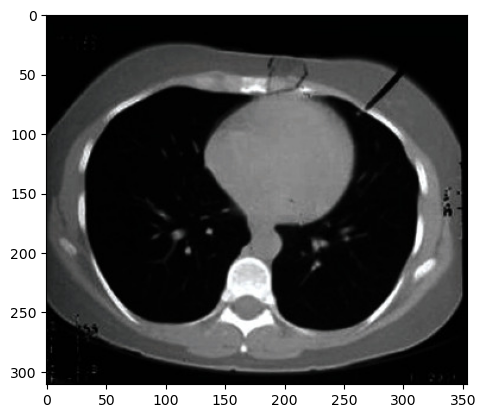

In [39]:
plt.imshow(valid_data[1]['image'])

image = valid_data[1]['image']
caption = valid_data[1]['text']

# Generate the prediction
gen_ = img_to_cap(image, model, processor, 'cuda')

print('source:\n',caption)
print('gen:\n',gen_)

source:
 Preoperative CT (axial plane) demonstrating appendix rupture with a gas containing collection (red arrows) adjacent to the caecum (green arrow). The collection contains multiple appendicoliths (white arrow).
gen:
 CT scan of the abdomen showing a large mass in the right lower quadrant.


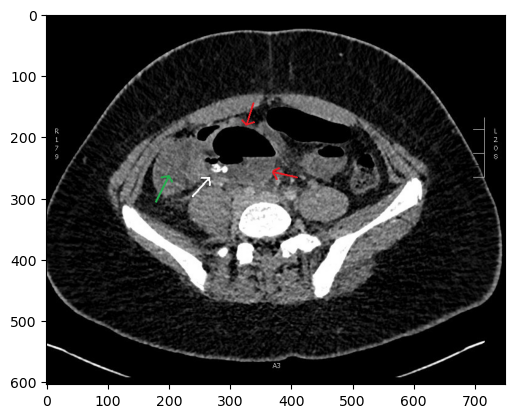

In [44]:
idx_ = 20
plt.imshow(valid_data[idx_]['image'])

image = valid_data[idx_]['image']
caption = valid_data[idx_]['text']

# Generate the prediction
gen_ = img_to_cap(image, model, processor, 'cuda')

print('source:\n',caption)
print('gen:\n',gen_)

source:
 Ultrasonography of the Right Femoral Vein StenosisThe ultrasound scan indicated suspected right femoral vein stenosis (arrow).
gen:
 Ultrasound of the right atrium showing a large mass in the right atrium (arrow).


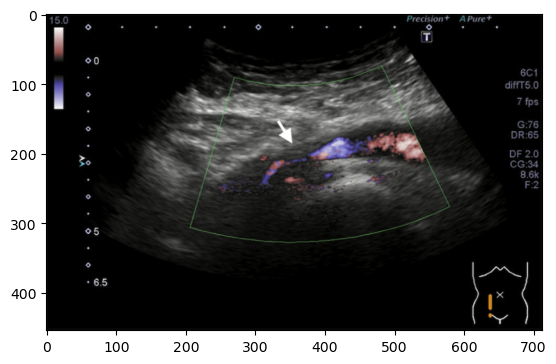

In [47]:
idx_ = 180
plt.imshow(valid_data[idx_]['image'])

image = valid_data[idx_]['image']
caption = valid_data[idx_]['text']

# Generate the prediction
gen_ = img_to_cap(image, model, processor, 'cuda')

print('source:\n',caption)
print('gen:\n',gen_)

source:
 Pre-operative OPG showing cyst-like lesion in the right coronoid process (pointed by yellow arrow). Linear radiopacity is the tracer gutta-percha point passed through the extra-oral cutaneous tract (pointed by blue arrows). The gutta percha point is seen abutting the cyst-like lesion in the coronoid process. OPG, orthopantomograph
gen:
 Axial view of the mandible showing the presence of a large mass in the mandibular fossa.


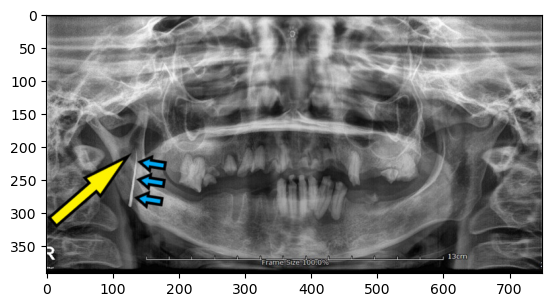

In [48]:
idx_ = 499
plt.imshow(valid_data[idx_]['image'])

image = valid_data[idx_]['image']
caption = valid_data[idx_]['text']

# Generate the prediction
gen_ = img_to_cap(image, model, processor, 'cuda')

print('source:\n',caption)
print('gen:\n',gen_)

In [49]:
! python /home/CinCin/bleu-rouge-meteor-cider-spice-eval4imagecaption/example/main.py

loading annotations into memory...
Done (t=0.01s)
creating index...
index created!
Loading and preparing results...
DONE (t=0.01s)
creating index...
index created!
tokenization...
Jul 20, 2024 12:01:45 PM edu.stanford.nlp.process.PTBLexer next
PTBTokenizer tokenized 177465 tokens at 935426.14 tokens per second.
PTBTokenizer tokenized 100282 tokens at 807772.94 tokens per second.
setting up scorers...
computing Bleu score...
{'testlen': 87482, 'reflen': 156069, 'guess': [87482, 80882, 74284, 67754], 'correct': [24659, 7115, 1739, 579]}
ratio: 0.5605341227277643
Bleu_1: 0.129
Bleu_2: 0.072
Bleu_3: 0.038
Bleu_4: 0.022
computing METEOR score...
METEOR: 0.063
computing Rouge score...
ROUGE_L: 0.175
computing CIDEr score...
CIDEr: 0.117
computing SPICE score...
Parsing reference captions
Initiating Stanford parsing pipeline
[main] INFO edu.stanford.nlp.pipeline.StanfordCoreNLP - Adding annotator tokenize
[main] INFO edu.stanford.nlp.pipeline.TokenizerAnnotator - TokenizerAnnotator: No tokeni

## Inference

In [ ]:
import torch
from matplotlib import pyplot as plt

device = "cuda" if torch.cuda.is_available() else "cpu"

fig = plt.figure(figsize=(18, 14))

# prepare image for the model
for i, example in enumerate(test_data):
  image = example["image"]
  inputs = processor(images=image, return_tensors="pt").to(device, torch.float16)
  pixel_values = inputs.pixel_values

  generated_ids = model.generate(pixel_values=pixel_values, max_length=25)
  generated_caption = processor.batch_decode(generated_ids, skip_special_tokens=True)[0]
  fig.add_subplot(2, 3, i+1)
  plt.imshow(image)
  plt.axis("off")
  plt.title(f"Generated caption: {generated_caption}")